In [19]:
# Import important libraries
import pandas as pd
import numpy as np
from random import choices
from itertools import compress

import matplotlib.pyplot as plt
from scipy.optimize import leastsq
import seaborn as sns
import math
global degree

In [20]:
# column names: 
# sin_orgination = the day since origination
# bef_chargeOff= before_charge_off
# when_charged_off = the when actually charged off
dtype_dict = {'sin_origination':int,
              'chargeOff':int}

loans = pd.read_csv('loan_timing.csv', dtype=dtype_dict)
loans.columns =[['sin_origination', 'chargeOff']]

# loans['when_charged_off']=loans['sin_origination']-loans['bef_chargeOff']
# Counting the number of NAN 
num_nan = sum(pd.isnull(loans['chargeOff']))
n = len(loans['chargeOff'])
#print(num_nan)
#print(n)
charged_off = loans['chargeOff']#[pd.isnull(loans['when_charged_off'])==False]

In [31]:
def polynomial_frame(feature, degree):
    # assume that degree >= 1
    # and set poly_sframe['power_1'] equal to the passed feature
    poly_sframe = pd.DataFrame(feature)
    poly_sframe.columns = ['power_1']
    # first check if degree > 1
    if degree > 1:
        # range usually starts at 0 and stops at the endpoint-1. We want it to start at 2 and stop at degree
        for power in range(2, degree+1): 
            # first we'll give the column a name:
            name = 'power_' + str(power)
            # then assign poly_sframe[name] to the appropriate power of feature
            #poly_sframe[name] = feature**power
            poly_sframe[name]= np.power(feature, power)
    return poly_sframe

def residuals_log2(p, y_true, x):
    #a,b,c,d, e= p
    tem_val = p[0]+p[1]*np.log(x)

    i = 1
    while(i<=degree):
        tem_val+=p[i+1]*np.power(x,degree)
        i+=1
    error = y_true-(tem_val)
    return error

def log_predict2(x, p, degree):
    #a,b, c,d,e = p
    res = p[0]+p[1]*np.log(x)
    i = degree
    while(i>=1):
        res+=p[i+1]*np.power(x,degree)
        i-=1
    #res = np.log(res)+p[-1]*x
    return res

def residual_sum_squares(y_true, y_predict):
    return sum(np.power(y_true-y_predict,2))

In [45]:
#Bootstrapping: start resampling and we are going to execute 1000 times
bootstrapping_num = 1000
predicted_res=[]
rss =[]
#weights=[0.5, 0.5]
import warnings
warnings.filterwarnings("ignore")
# Parameter initialization
temp_loans = loans['chargeOff'][pd.isnull(loans['chargeOff'])==False]
x =np.linspace(30, max(temp_loans),  int((max(temp_loans)- 30)/30))
x = x.astype(int)
x_extra = np.linspace(30, 1080,  int((max(temp_loans)- 30)/30))

t = 360*3
kk=1
while(kk<=bootstrapping_num):
    #charged_off = loans['when_charged_off']#[pd.isnull(loans['when_charged_off'])==False]
    resampling = choices(charged_off, k=len(charged_off))   
    
    charged_off2 = list(compress(resampling, ~np.isnan(resampling)))
    y =[]
    for i in x:
        y.append(sum(charged_off2<=i))
    y_percent=[]
    for i in y:
        if(i==0): 
            y_percent.append(1/n*100)
        else:
            y_percent.append(i/n*100)
    
    y_per_log= [math.log(i) for i in y_percent]    
    # Result for each prediction
    log_y_predict2=[]
    temp_predict = []
    coeff2=dict()
    degree = 1
    p0 = [3, 1, 1]
    i = degree
    while(i>=1):
        p0.append(0)
        i-=1
   
    plsq = leastsq(residuals_log2, p0, args=(y_per_log, x))
    log_y_predict2 = log_predict2(x_extra, plsq[0], degree)
    coeff2=plsq[0]
    temp_predict = log_predict2(x, plsq[0], degree)
        
    #temp_final_y = weights[0]*temp_predict[0]+weights[1]*temp_predict[1]
    rss.append(residual_sum_squares(y_per_log,temp_predict ))
    temp_res = np.exp(log_predict2(t, coeff2,degree))
    predicted_res.append(temp_res)
    #print(str(np.exp(log_predict2(t, coeff2, degree)))+'%')

    
    if ((kk % 50)==0):
        print("Current run: %(n)s \t Output: %(s)s%%" % {'n': kk, 's': temp_res})
    kk+=1
    #print("Current run: %s, \t Result: %3.f", [kk,temp_res])

Current run: 50 	 Output: 6.4082817861%
Current run: 100 	 Output: 6.28965639532%
Current run: 150 	 Output: 6.18370976448%
Current run: 200 	 Output: 6.32054311066%
Current run: 250 	 Output: 6.40954652357%
Current run: 300 	 Output: 6.2463126974%
Current run: 350 	 Output: 6.23053458357%
Current run: 400 	 Output: 6.52526525261%
Current run: 450 	 Output: 6.07361092036%
Current run: 500 	 Output: 6.23034266157%
Current run: 550 	 Output: 6.38256624881%
Current run: 600 	 Output: 6.54055728396%
Current run: 650 	 Output: 6.04777478971%
Current run: 700 	 Output: 6.74156309623%
Current run: 750 	 Output: 6.51447132005%
Current run: 800 	 Output: 6.35203908803%
Current run: 850 	 Output: 6.42613193994%
Current run: 900 	 Output: 6.50632125014%
Current run: 950 	 Output: 6.16524769058%
Current run: 1000 	 Output: 6.23271433512%


In [46]:
len(predicted_res)

1000

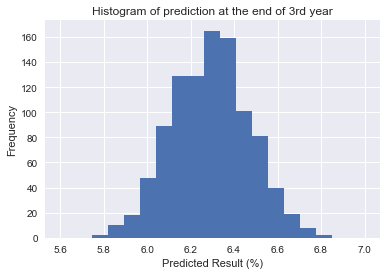

6.29420502936
0.17719709051904006
6.30062107723


In [55]:
from statistics import mean, stdev, median
bins =np.linspace(5.6, 7,  20)
sns.set()
plt.hist(predicted_res, bins=bins)
plt.xlabel('Predicted Result (%)')
plt.ylabel('Frequency')
plt.title('Histogram of prediction at the end of 3rd year')
plt.show()
print(np.mean(predicted_res))
print(stdev(predicted_res))
print(median(predicted_res))

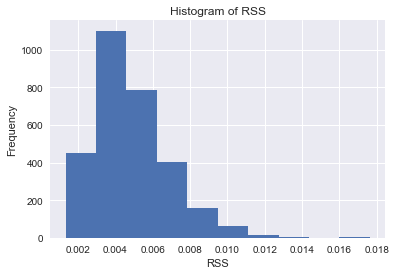

7.30089419076


In [12]:
#bins =np.linspace(6.5, 8,  20)
sns.set()
plt.hist(rss)
plt.xlabel('RSS')
plt.ylabel('Frequency')
plt.title('Histogram of RSS')
plt.show()
print(np.mean(predicted_res))

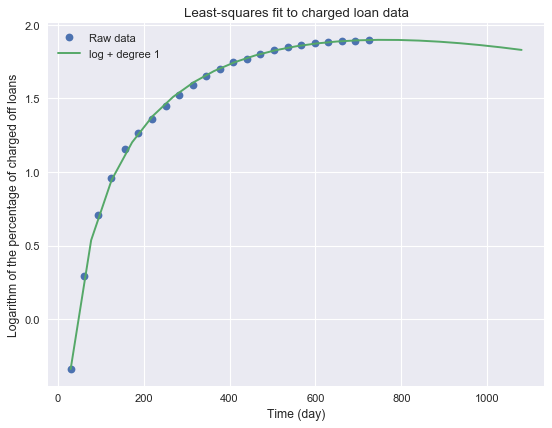

In [57]:
    plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(x,y_per_log,'o',label='Data')
    #for i in range(4):
    plt.plot(x_extra,log_y_predict2)
    #plt.plot(x_extra, log_y_predict[1])
    plt.title('Least-squares fit to charged loan data')
    plt.legend(['Raw data','log + degree 1'])
    plt.ylabel('Logarithm of the percentage of charged off loans')
    plt.xlabel('Time (day)')
    plt.show()

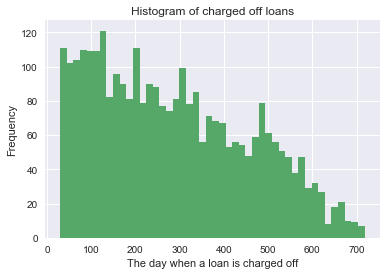

In [87]:
bins =np.linspace(30, max(charged_off),  int((max(charged_off))/15))
sns.set()
plt.hist(charged_off, bins)
plt.xlabel('The day when a loan is charged off')
plt.ylabel('Frequency')
plt.title('Histogram of charged off loans')
plt.show()